In [15]:
import pandas as pd

print("--- Starting Merge Process ---")

try:
    # Load both original CSVs
    df_annotations = pd.read_csv("content/annotations.csv")
    df_bbox = pd.read_csv("content/bbox.csv")
    merged_path = "content/merged_turtle_data.csv"

    print("Loaded annotations.csv and bbox.csv")

    # Merge them
    # 'path' in annotations.csv is the same as 'image_name' in bbox.csv
    df_merged = pd.merge(df_annotations, df_bbox, left_on='path', right_on='image_name')

    print(f"Merge successful. New table has {len(df_merged)} rows.")

    # Save the new merged file
    df_merged.to_csv(merged_path, index=False)

    print("\nSuccessfully created 'merged_turtle_data.csv'!")
    print("\nColumns in new file:")
    print(df_merged.columns.to_list())

    print("\nHead of merged file:")
    print(df_merged.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'annotations.csv' and 'bbox.csv' are in your /content/ directory.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Starting Merge Process ---
Loaded annotations.csv and bbox.csv
Merge successful. New table has 160 rows.

Successfully created 'merged_turtle_data.csv'!

Columns in new file:
['identity', 'path', 'orientation', 'date', 'label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_name', 'image_width', 'image_height']

Head of merged file:
  identity               path orientation        date label_name  bbox_x  \
0   G16-25   leftIMG_0958.JPG        left  22_06_2018       head    1137   
1   G16-25  rightIMG_0961.JPG       right  22_06_2018       head    2764   
2   G16-25   leftIMG_1300.JPG        left  08_07_2020       head    1331   
3   G16-25  rightIMG_1280.JPG       right  08_07_2020       head    2676   
4     t551   leftIMG_1084.JPG        left  07_06_2023       head    1919   

   bbox_y  bbox_width  bbox_height         image_name  image_width  \
0     953         607          523   leftIMG_0958.JPG         5472   
1    1232         843          664  rightIMG_0961.

In [ ]:
import cv2

**Step 1: Preprocessing**

In [ ]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_contrast = clahe.apply(blurred)
    return enhanced_contrast

**Step 2: Head Detection (ROI)**

In [ ]:
def get_head_roi(image, bbox):
    x, y, w, h = bbox
    x, y, w, h = int(x), int(y), int(w), int(h)
    roi = image[y:y+h, x:x+w]
    return roi

**Step 3: Rotate (Registration)**

In [ ]:
def register_head(image, orientation):
    if orientation == 'right':
        return cv2.flip(image, 1) # Horizontal flip
    else:
        return image

**Step 4: Segmentation**

In [ ]:
def segment_pattern(image):
    segmented = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )
    return segmented

**Demostration**

Successfully loaded content/merged_turtle_data.csv with 160 records.
--- Running Pipeline Demonstration ---
Saved pipeline demonstration to report_example_leftIMG_0958.JPG.png

Demonstration complete. Check the saved .png file.


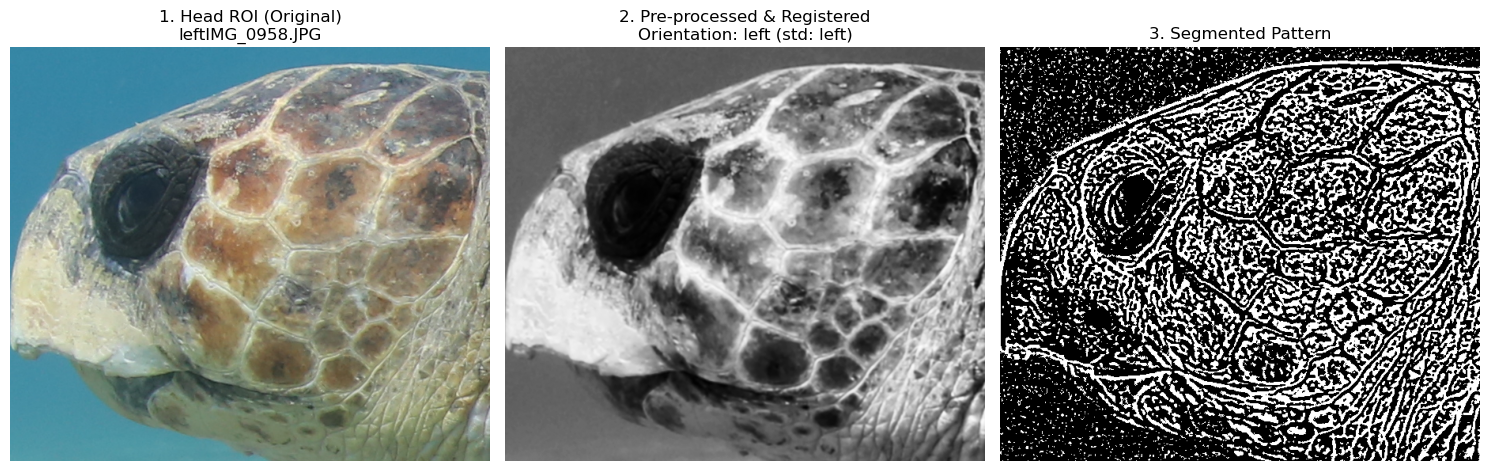

In [ ]:
import pandas as pd
import numpy as np
import cv2  # This is the OpenCV library
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the paths
IMAGE_DIR = "content/images/"
# --- THIS FILE NOW EXISTS ---
CSV_FILE = "content/merged_turtle_data.csv" 

# --- Load the MERGED metadata into the 'df' variable ---
try:
    df = pd.read_csv(CSV_FILE)
    print(f"Successfully loaded {CSV_FILE} with {len(df)} records.")
except FileNotFoundError:
    print(f"ERROR: Could not find {CSV_FILE}.")
    print("Please make sure you ran Step A first.")
except Exception as e:
    print(f"An error occurred loading the CSV: {e}")

# --- DEFINE THE DEMONSTRATION FUNCTION ---

def demonstrate_pipeline(row):
    """
    Runs one image through the full pipeline (Steps 1-4)
    and saves a comparison plot.
    """
    try:
        # Get the metadata from the DataFrame row
        image_name = row['image_name']
        image_path = os.path.join(IMAGE_DIR, image_name)
        
        # --- These columns are now available in the 'row' ---
        orientation = row['orientation'] 
        bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]

        # --- Load the Original Image ---
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Warning: Could not load image {image_path}. Skipping.")
            return None

        # --- RUN THE PIPELINE ---
        preprocessed_full = preprocess_image(original_image)
        roi_gray = get_head_roi(preprocessed_full, bbox)
        roi_color = get_head_roi(original_image, bbox)
        roi_color_rgb = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB) # For Matplotlib
        roi_registered = register_head(roi_gray, orientation)
        roi_segmented = segment_pattern(roi_registered)

        # --- Plot and Save Results ---
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(roi_color_rgb)
        axes[0].set_title(f"1. Head ROI (Original)\n{image_name}")
        axes[0].axis('off')
        
        axes[1].imshow(roi_registered, cmap='gray')
        axes[1].set_title(f"2. Pre-processed & Registered\nOrientation: {orientation} (std: left)")
        axes[1].axis('off')
        
        axes[2].imshow(roi_segmented, cmap='gray')
        axes[2].set_title("3. Segmented Pattern")
        axes[2].axis('off')
        
        plt.tight_layout()
        output_filename = f"report_example_{image_name}.png"
        plt.savefig(output_filename)
        print(f"Saved pipeline demonstration to {output_filename}")
        
        return roi_registered

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        return None

# --- Run the demonstration on the first image in the dataframe ---
if 'df' in locals() and not df.empty:
    print("--- Running Pipeline Demonstration ---")
    # Get the first row (this will be 'leftIMG_0958.JPG' from the merged file)
    example_row = df.iloc[0] 

    # Run the pipeline
    processed_roi_for_next_step = demonstrate_pipeline(example_row)
    
    if processed_roi_for_next_step is not None:
        print("\nDemonstration complete. Check the saved .png file.")
else:
    print("\nSkipping demonstration because the DataFrame 'df' is not loaded.")

**Step 5: Pattern Recognition**

In [ ]:
print("--- Initializing Step 5 (Pattern Recognition) ---")

# Initialize the ORB detector
# We'll try to find up to 2000 key features in each image.
try:
    orb = cv2.ORB_create(nfeatures=2000)
    print("ORB Detector created.")
except Exception as e:
    print(f"Error creating ORB detector. Make sure your OpenCV version is correct. {e}")


# 1. Create the Feature Database
def create_feature_database(df_train):
    """
    Processes all images in the training set and stores
    their features (keypoints & descriptors) in a list.
    """
    print(f"\nCreating feature database for {len(df_train)} training images...")
    feature_database = []
    
    for index, row in df_train.iterrows():
        try:
            image_name = row['image_name']
            image_path = os.path.join(IMAGE_DIR, image_name)
            
            # Load the original image
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Could not load {image_path} for database. Skipping.")
                continue

            # --- Run Steps 1-3 from our pipeline ---
            # We use the advanced pre-processing function if you have it
            # Or the standard 'preprocess_image' function
            preprocessed_full = preprocess_image(original_image)
            
            bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
            roi_gray = get_head_roi(preprocessed_full, bbox)
            roi_registered = register_head(roi_gray, row['orientation'])
            
            # --- Feature Extraction (Step 5a) ---
            # Find keypoints and descriptors with ORB
            # We use the pre-processed (gray, registered) ROI,
            # NOT the segmented one, as ORB needs texture.
            keypoints, descriptors = orb.detectAndCompute(roi_registered, None)
            
            if descriptors is not None and len(descriptors) > 0:
                feature_database.append({
                    'identity': row['identity'],
                    'image_name': image_name,
                    'descriptors': descriptors
                })
            else:
                print(f"Warning: No descriptors found for {image_name}. Skipping.")
                
        except Exception as e:
            print(f"Error during feature extraction for {image_name}: {e}")
            
    print(f"Database creation complete. Stored features for {len(feature_database)} images.")
    return feature_database


# 2. Match a Test Image against the Database
def identify_turtle(test_image_processed, database):
    """
    Finds the best match for a new test image
    against the feature database.
    """
    # Initialize the Brute-Force Matcher
    # cv2.NORM_HAMMING is the correct distance measure for ORB
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Find features in the *test* image
    test_kp, test_desc = orb.detectAndCompute(test_image_processed, None)
    
    if test_desc is None or len(test_desc) == 0:
        # print("Could not find any features in the test image.")
        return None # No features to match

    all_matches_by_identity = {}
    
    # Loop through every image in our database
    for db_entry in database:
        db_desc = db_entry['descriptors']
        db_identity = db_entry['identity']
        
        try:
            # Find matches between test image and this database image
            matches = bf.match(test_desc, db_desc)
            
            # Keep only "good" matches
            # A good match is one with a low "distance".
            # For ORB, a distance < 50 is a common starting point.
            # You can TUNE this value to get better results.
            good_matches = [m for m in matches if m.distance < 50]
            
            num_good_matches = len(good_matches)
            
            # --- This is a more robust way to score ---
            # We sum the matches for each IDENTITY, not just each image.
            # This prevents one lucky match from skewing the result.
            if db_identity not in all_matches_by_identity:
                all_matches_by_identity[db_identity] = 0
            
            all_matches_by_identity[db_identity] += num_good_matches

        except cv2.error as e:
            # This can happen if descriptor formats mismatch, etc.
            # print(f"Matcher error comparing with {db_entry['image_name']}: {e}")
            pass

    if not all_matches_by_identity:
        # print("No good matches found against the entire database.")
        return None

    # Sort all results by the number of good matches (descending)
    sorted_results = sorted(
        all_matches_by_identity.items(), 
        key=lambda item: item[1],  # item[1] is the number of matches
        reverse=True
    )
    
    # The top result is our prediction
    # Format: [('turtle_id_A', 150), ('turtle_id_B', 95), ...]
    return sorted_results

--- Initializing Step 5 (Pattern Recognition) ---
ORB Detector created.


**Step 6: Evaluation**

In [ ]:
def evaluate_system(df):
    """
    Splits the data, runs the full identification pipeline,
    and calculates Top-1 Accuracy.
    """
    print("\n--- Starting Full System Evaluation ---")
    
    # --- 1. Train/Test Split ---
    # We MUST split by IDENTITY, not by image.
    # This ensures images of the same turtle aren't in both sets.
    all_identities = df['identity'].unique()
    
    if len(all_identities) < 2:
        print("Error: Not enough unique identities to perform a train/test split.")
        return

    # test_size=0.3 means 30% of identities will be for testing
    # random_state=42 ensures the split is the same every time you run it
    train_ids, test_ids = train_test_split(
        all_identities, 
        test_size=0.3, 
        random_state=42
    )
    
    # Create the train and test dataframes
    df_train = df[df['identity'].isin(train_ids)]
    df_test = df[df['identity'].isin(test_ids)]
    
    print(f"Total Identities: {len(all_identities)}")
    print(f"Training Identities: {len(train_ids)} ({len(df_train)} images)")
    print(f"Testing Identities: {len(test_ids)} ({len(df_test)} images)")
    
    if len(df_train) == 0 or len(df_test) == 0:
        print("Error: Train or Test set is empty. Cannot proceed.")
        return

    # --- 2. Create Feature Database ---
    feature_database = create_feature_database(df_train)
    
    if not feature_database:
        print("Database is empty. Evaluation cannot proceed.")
        return

    # --- 3. Run Evaluation Loop ---
    correct_predictions = 0
    total_predictions = 0
    
    print(f"\n--- Running Evaluation on {len(df_test)} Test Images ---")
    
    for index, row in df_test.iterrows():
        try:
            true_identity = row['identity']
            image_name = row['image_name']
            image_path = os.path.join(IMAGE_DIR, image_name)

            # Load and process the test image
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Warning: Could not load test image {image_name}. Skipping.")
                continue

            # Run Steps 1-3 to get the processed ROI
            preprocessed_full = preprocess_image(original_image)
            bbox = [row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']]
            roi_gray = get_head_roi(preprocessed_full, bbox)
            roi_registered = register_head(roi_gray, row['orientation'])
            
            # --- 4. Identify ---
            # This returns a sorted list of all potential matches
            # e.g., [('G16-25', 120), ('t551', 80), ...]
            results = identify_turtle(roi_registered, feature_database)
            
            if not results:
                print(f"  > No match found for {image_name} ({true_identity}).")
                continue

            # The prediction is the identity from the top-scoring match
            predicted_identity = results[0][0]
            num_matches = results[0][1]

            # --- 5. Check Accuracy ---
            if predicted_identity == true_identity:
                correct_predictions += 1
                print(f"  > CORRECT: '{image_name}' ({true_identity}) -> '{predicted_identity}' ({num_matches} matches)")
            else:
                print(f"  > WRONG:   '{image_name}' ({true_identity}) -> '{predicted_identity}' ({num_matches} matches)")
            
            total_predictions += 1

        except Exception as e:
            print(f"Error during evaluation of {image_name}: {e}")

    # --- 6. Calculate Final Accuracy ---
    if total_predictions > 0:
        accuracy = (correct_predictions / total_predictions) * 100
        print("\n--- Evaluation Complete ---")
        print(f"Total Test Images Evaluated: {total_predictions}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Top-1 Accuracy: {accuracy:.2f}%")
    else:
        print("\n--- Evaluation Complete ---")
        print("No predictions were made. Check image paths and processing steps.")

# --- Run the Full Evaluation ---
# We check if the 'df' variable exists and is not empty
if 'df' in locals() and not df.empty:
    evaluate_system(df)
else:
    print("\nDataFrame 'df' not loaded. Please run the setup cell first.")


--- Starting Full System Evaluation ---
Total Identities: 40
Training Identities: 28 (112 images)
Testing Identities: 12 (48 images)

Creating feature database for 112 training images...
Database creation complete. Stored features for 112 images.

--- Running Evaluation on 48 Test Images ---
  > WRONG:   'rightIMG_5626.JPG' (t499) -> 't573' (866 matches)
  > WRONG:   'leftIMG_5632.JPG' (t499) -> 't573' (715 matches)
  > WRONG:   'rightIMG_1446.JPG' (t499) -> 't573' (310 matches)
  > WRONG:   'leftIMG_1457.JPG' (t499) -> 't521' (502 matches)
  > WRONG:   'rightIMG_2776.JPG' (G17-02) -> 't521' (797 matches)
  > WRONG:   'leftIMG_2799.JPG' (G17-02) -> 't521' (859 matches)
  > WRONG:   'rightIMG_7378.JPG' (G17-02) -> 't573' (882 matches)
  > WRONG:   'leftIMG_7373.JPG' (G17-02) -> 't521' (686 matches)
  > WRONG:   'leftIMG_7201.JPG' (t584) -> 't573' (741 matches)
  > WRONG:   'rightIMG_7191.JPG' (t584) -> 'G15-03' (56 matches)
  > WRONG:   'rightIMG_7873.JPG' (t584) -> 't573' (1103 matche